In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

X_train_full = train_df.drop('smoking', axis=1)
y_train_full = train_df['smoking']
X_test_final = test_df.copy()

print(f"Train: {train_df.shape}, Test: {test_df.shape}")
print(f"Class balance: {y_train_full.value_counts(normalize=True).to_dict()}")

Train: (38984, 23), Test: (16708, 22)
Class balance: {0: 0.6327211163554278, 1: 0.3672788836445721}


In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train_full
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}")

Train: (31187, 22), Val: (7797, 22)


In [4]:
def create_health_features(df):
    df_new = df.copy()
    df_new['BMI'] = df_new['weight(kg)'] / ((df_new['height(cm)'] / 100) ** 2)
    df_new['waist_height_ratio'] = df_new['waist(cm)'] / df_new['height(cm)']
    df_new['total_hdl_ratio'] = df_new['Cholesterol'] / (df_new['HDL'] + 1)
    df_new['ldl_hdl_ratio'] = df_new['LDL'] / (df_new['HDL'] + 1)
    df_new['ast_alt_ratio'] = df_new['AST'] / (df_new['ALT'] + 1)
    df_new['pulse_pressure'] = df_new['systolic'] - df_new['relaxation']
    df_new['eyesight_avg'] = (df_new['eyesight(left)'] + df_new['eyesight(right)']) / 2
    df_new['eyesight_diff'] = np.abs(df_new['eyesight(left)'] - df_new['eyesight(right)'])
    df_new['hearing_avg'] = (df_new['hearing(left)'] + df_new['hearing(right)']) / 2
    df_new['age_squared'] = df_new['age'] ** 2
    df_new['age_cubed'] = df_new['age'] ** 3
    return df_new

X_train_eng = create_health_features(X_train)
X_val_eng = create_health_features(X_val)
X_train_full_eng = create_health_features(X_train_full)
X_test_eng = create_health_features(X_test_final)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_val_scaled = scaler.transform(X_val_eng)
X_train_full_scaled = scaler.transform(X_train_full_eng)
X_test_scaled = scaler.transform(X_test_eng)

print(f"Total features: {X_train_eng.shape[1]}")

Total features: 33


In [5]:
selector = SelectKBest(score_func=f_classif, k=25)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_selected = selector.transform(X_val_scaled)

feature_scores = pd.DataFrame({
    'feature': X_train_eng.columns,
    'score': selector.scores_
}).sort_values('score', ascending=False)

print("Top 10 features:")
print(feature_scores.head(10))

Top 10 features:
             feature        score
15        hemoglobin  6065.618690
1         height(cm)  5940.689330
2         weight(kg)  3177.627958
12      triglyceride  2086.303839
20               Gtp  1938.329429
3          waist(cm)  1697.710177
17  serum creatinine  1466.264556
26     ast_alt_ratio  1052.745666
13               HDL  1050.502667
0                age   962.549938


In [6]:
baseline_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced')
baseline_model.fit(X_train_selected, y_train)

y_val_pred = baseline_model.predict(X_val_selected)
y_val_prob = baseline_model.predict_proba(X_val_selected)[:, 1]

print(f"Baseline Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Baseline F1: {f1_score(y_val, y_val_pred):.4f}")
print(f"Baseline ROC-AUC: {roc_auc_score(y_val, y_val_prob):.4f}")

Baseline Accuracy: 0.7164
Baseline F1: 0.6699
Baseline ROC-AUC: 0.8036


In [7]:
def objective(trial):
    C = trial.suggest_float('C', 0.001, 100, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    k_features = trial.suggest_int('k_features', 15, 35)
    
    selector_trial = SelectKBest(score_func=f_classif, k=k_features)
    X_train_trial = selector_trial.fit_transform(X_train_scaled, y_train)
    X_val_trial = selector_trial.transform(X_val_scaled)
    
    model = LogisticRegression(C=C, penalty=penalty, solver=solver, class_weight=class_weight, random_state=RANDOM_STATE, max_iter=2000)
    cv_scores = cross_val_score(model, X_train_trial, y_train, cv=StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE), scoring='roc_auc', n_jobs=-1)
    return cv_scores.mean()

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=40, show_progress_bar=True)

print(f"Best ROC-AUC: {study.best_value:.4f}")
print(f"Best params: {study.best_params}")

[I 2025-12-08 12:58:00,649] A new study created in memory with name: no-name-8b6a070c-8881-4cb3-8af0-2e5c0b903b47


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-12-08 12:58:07,859] Trial 0 finished with value: 0.8096726204680088 and parameters: {'C': 0.0745934328572655, 'penalty': 'l1', 'class_weight': 'balanced', 'k_features': 18}. Best is trial 0 with value: 0.8096726204680088.
[I 2025-12-08 12:58:11,561] Trial 1 finished with value: 0.7980701547226783 and parameters: {'C': 0.0019517224641449498, 'penalty': 'l1', 'class_weight': 'balanced', 'k_features': 35}. Best is trial 0 with value: 0.8096726204680088.
[I 2025-12-08 12:59:01,563] Trial 2 finished with value: 0.8135550555163868 and parameters: {'C': 14.528246637516036, 'penalty': 'l1', 'class_weight': None, 'k_features': 26}. Best is trial 2 with value: 0.8135550555163868.
[I 2025-12-08 12:59:02,093] Trial 3 finished with value: 0.8104438017843745 and parameters: {'C': 0.14445251022763064, 'penalty': 'l2', 'class_weight': None, 'k_features': 22}. Best is trial 2 with value: 0.8135550555163868.
[I 2025-12-08 12:59:08,691] Trial 4 finished with value: 0.8079623814057836 and paramete

In [8]:
best_params = study.best_params
final_selector = SelectKBest(score_func=f_classif, k=best_params['k_features'])
X_train_full_selected = final_selector.fit_transform(X_train_full_scaled, y_train_full)
X_test_selected = final_selector.transform(X_test_scaled)
X_val_final_selected = final_selector.transform(X_val_scaled)

final_model = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver='liblinear' if best_params['penalty'] == 'l1' else 'lbfgs',
    class_weight=best_params['class_weight'],
    random_state=RANDOM_STATE,
    max_iter=2000
)
final_model.fit(X_train_full_selected, y_train_full)

print("Final model trained")

Final model trained


In [9]:
y_val_final_pred = final_model.predict(X_val_final_selected)
y_val_final_prob = final_model.predict_proba(X_val_final_selected)[:, 1]

print(f"Accuracy:  {accuracy_score(y_val, y_val_final_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_val_final_pred):.4f}")
print(f"Recall:    {recall_score(y_val, y_val_final_pred):.4f}")
print(f"F1-Score:  {f1_score(y_val, y_val_final_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_val, y_val_final_prob):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_final_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_final_pred, target_names=['Non-Smoker', 'Smoker']))

selected_features = X_train_full_eng.columns[final_selector.get_support()]
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'coefficient': final_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)
print("\nTop 10 Important Features:")
print(feature_importance.head(10))

Accuracy:  0.7218
Precision: 0.6339
Recall:    0.5744
F1-Score:  0.6027
ROC-AUC:   0.8061

Confusion Matrix:
[[3983  950]
 [1219 1645]]

Classification Report:
              precision    recall  f1-score   support

  Non-Smoker       0.77      0.81      0.79      4933
      Smoker       0.63      0.57      0.60      2864

    accuracy                           0.72      7797
   macro avg       0.70      0.69      0.69      7797
weighted avg       0.72      0.72      0.72      7797


Top 10 Important Features:
               feature  coefficient
3            waist(cm)     4.723649
23  waist_height_ratio    -4.367942
2           weight(kg)    -3.618835
22                 BMI     2.541637
29         age_squared     1.683583
30           age_cubed    -1.426161
25       ldl_hdl_ratio     1.106991
14                 LDL    -0.954661
15          hemoglobin     0.702393
24     total_hdl_ratio    -0.611159


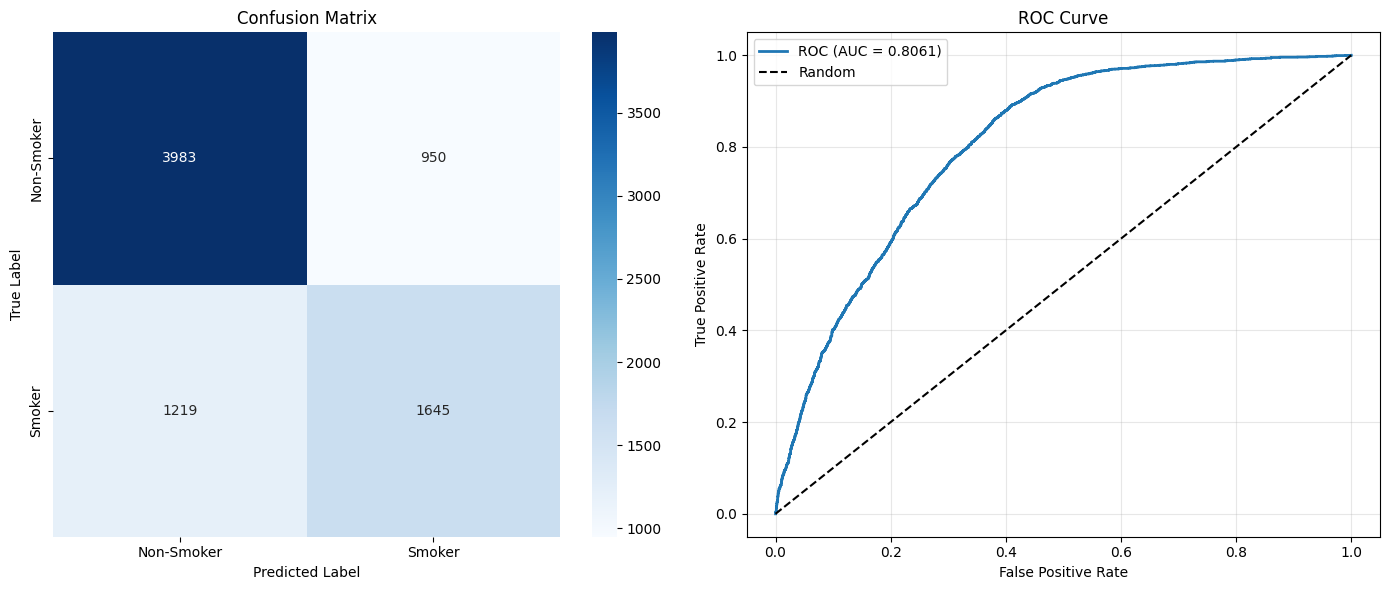

In [10]:
cm = confusion_matrix(y_val, y_val_final_pred)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'], ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

fpr, tpr, _ = roc_curve(y_val, y_val_final_prob)
axes[1].plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_val, y_val_final_prob):.4f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()